EfficientNet-B1 is ideal when you need better accuracy than B0 while maintaining reasonable efficiency, making it suitable for tasks like medical imaging (e.g., brain tumor detection) where fine details matter. With 7.8M parameters and a 240x240 input resolution, it captures more complex patterns than B0 but remains lightweight enough for GPUs in Kaggle or Colab. Use B1 when your dataset benefits from slightly deeper feature extraction and you can afford marginally slower training. However, for edge deployment or real-time applications, B0 is preferable due to its lower computational cost. B1 strikes a balance—offering improved performance over B0 without the heavy resource demands of larger models like B2-B7. For your brain tumor classification, B1 is a strong choice if hardware constraints allow.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

#  Install EfficientNet

In [2]:
# Install only the necessary library (no dependencies to avoid conflicts)
!pip install efficientnet-pytorch --no-deps --quiet
print("✅ EfficientNet-B1 environment ready!")

  Preparing metadata (setup.py) ... done
✅ EfficientNet-B1 environment ready!


# Imports & GPU Setup

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from efficientnet_pytorch import EfficientNet

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

🚀 Using device: cuda


# Dataset Preparation

In [4]:
# Configuration
data_dir = '/kaggle/input/brain-tumor-mri-dataset/'
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Create DataFrame with image paths and labels
image_paths = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, 'Training', class_name)
    for img in os.listdir(class_dir):
        if img.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(class_dir, img))
            labels.append(class_idx)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"📊 Dataset split: {len(train_df)} train, {len(test_df)} test samples")

📊 Dataset split: 4569 train, 1143 test samples


# Data Transforms & Dataset Class

In [5]:
# EfficientNet-B1 specific transforms (240x240 input)
transform = transforms.Compose([
    transforms.Resize((240, 240)),  # B1 requires 240x240
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

# Custom Dataset
class BrainMRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')  # Force 3-channel
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Initialize datasets
train_dataset = BrainMRIDataset(train_df, transform)
test_dataset = BrainMRIDataset(test_df, transform)

# Before-Training Visualization

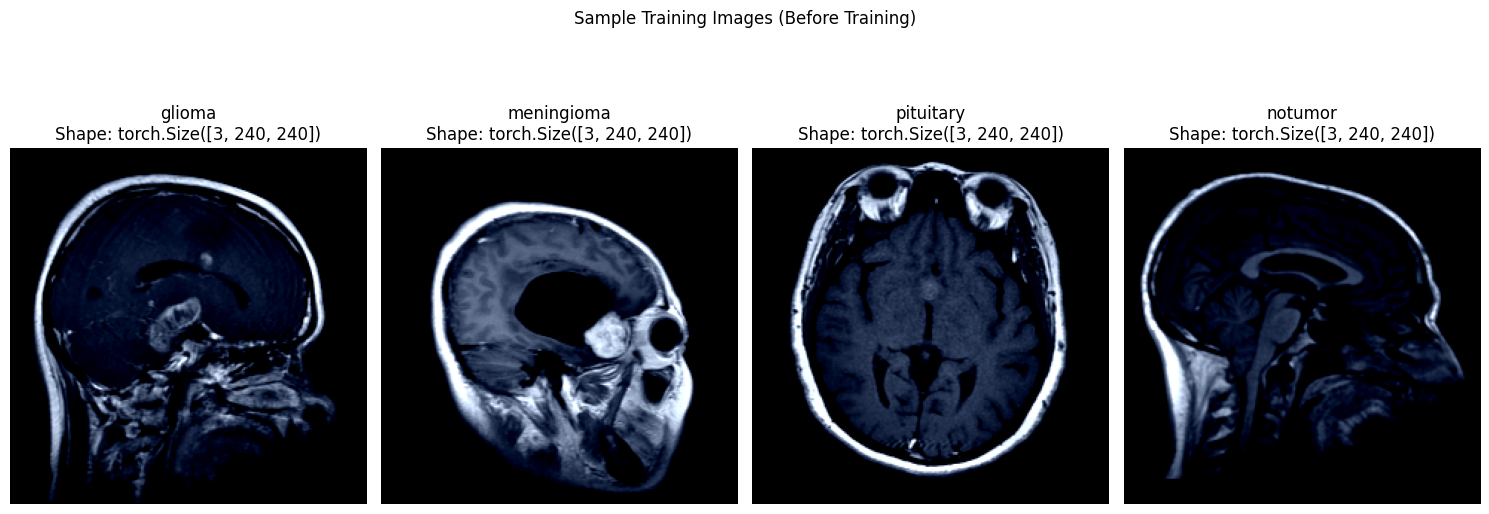

In [6]:
# Display sample images from each class
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    # Get first image of each class
    sample = next(img for img, label in train_dataset if label == i)
    plt.subplot(1, 4, i+1)
    plt.imshow(sample.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
    plt.title(f"{cls}\nShape: {sample.shape}")
    plt.axis('off')
plt.suptitle("Sample Training Images (Before Training)", y=1.1)
plt.tight_layout()
plt.show()

# Data Loaders

In [7]:
# Batch size 32 for balance between speed and memory
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
print("⚡ Data loaders ready (batch_size=32)")

⚡ Data loaders ready (batch_size=32)


# Initialize EfficientNet-B1

In [8]:
# Load pretrained B1 model
model = EfficientNet.from_pretrained('efficientnet-b1')
model._fc = nn.Linear(model._fc.in_features, len(classes))  # Adjust final layer
model = model.to(device)

# Freeze all layers except last block + classifier
for param in model.parameters():
    param.requires_grad = False
for layer in [model._conv_head, model._bn1, model._fc]:
    for param in layer.parameters():
        param.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
print("🧠 EfficientNet-B1 initialized (last layers unfrozen)!")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 267MB/s]


Loaded pretrained weights for efficientnet-b1
🧠 EfficientNet-B1 initialized (last layers unfrozen)!


# Training Loop (15 Epochs)

In [9]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(15):
    # Training phase
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Calculate metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100 * train_correct / len(train_dataset)
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = 100 * val_correct / len(test_dataset)
    
    # Store for plotting
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/15:")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}%")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}%\n")

Epoch 1/15:
  Train Loss: 0.4240 | Acc: 85.07%
  Val Loss: 0.3770 | Acc: 85.83%

Epoch 2/15:
  Train Loss: 0.2102 | Acc: 93.04%
  Val Loss: 0.5195 | Acc: 80.66%

Epoch 3/15:
  Train Loss: 0.1583 | Acc: 94.53%
  Val Loss: 0.4227 | Acc: 84.69%

Epoch 4/15:
  Train Loss: 0.1175 | Acc: 95.47%
  Val Loss: 0.3588 | Acc: 86.18%

Epoch 5/15:
  Train Loss: 0.1005 | Acc: 96.56%
  Val Loss: 0.1605 | Acc: 94.84%

Epoch 6/15:
  Train Loss: 0.0853 | Acc: 96.87%
  Val Loss: 0.1093 | Acc: 95.71%

Epoch 7/15:
  Train Loss: 0.0773 | Acc: 97.22%
  Val Loss: 0.1295 | Acc: 95.89%

Epoch 8/15:
  Train Loss: 0.0672 | Acc: 97.86%
  Val Loss: 0.1187 | Acc: 95.63%

Epoch 9/15:
  Train Loss: 0.0636 | Acc: 97.88%
  Val Loss: 0.1276 | Acc: 96.50%

Epoch 10/15:
  Train Loss: 0.0459 | Acc: 98.58%
  Val Loss: 0.1163 | Acc: 97.20%

Epoch 11/15:
  Train Loss: 0.0434 | Acc: 98.53%
  Val Loss: 0.1363 | Acc: 96.41%

Epoch 12/15:
  Train Loss: 0.0428 | Acc: 98.53%
  Val Loss: 0.1709 | Acc: 95.80%

Epoch 13/15:
  Train Loss

# Post-Training Visualizations

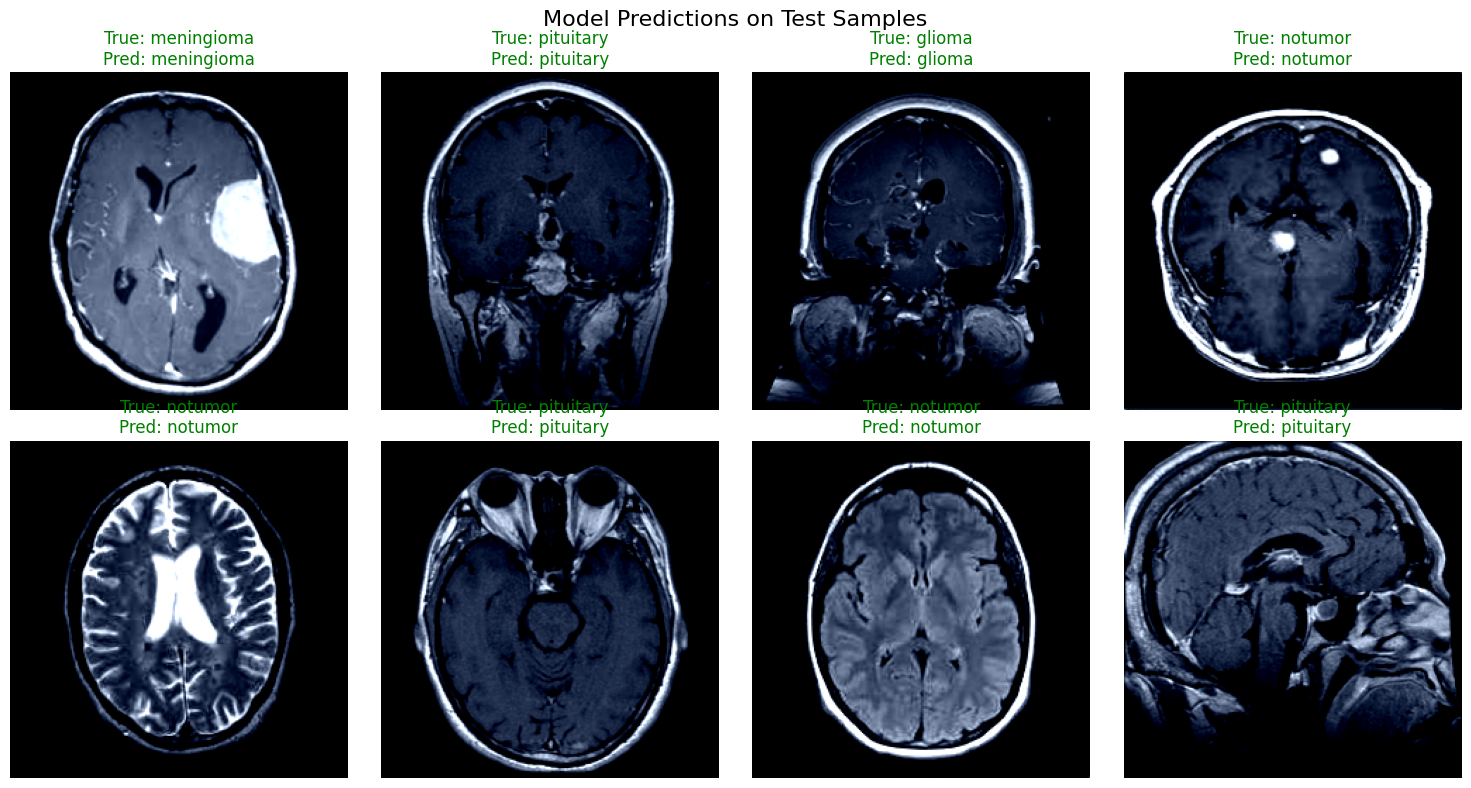

In [10]:
# 1. Sample Predictions
model.eval()
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i in range(8):
    img, label = test_dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax().item()
    
    axes[i//4, i%4].imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[i//4, i%4].set_title(f"True: {classes[label]}\nPred: {classes[pred]}", 
                            color='green' if pred == label else 'red')
    axes[i//4, i%4].axis('off')
plt.suptitle("Model Predictions on Test Samples", fontsize=16)
plt.tight_layout()
plt.show()


# Result and Evaluation

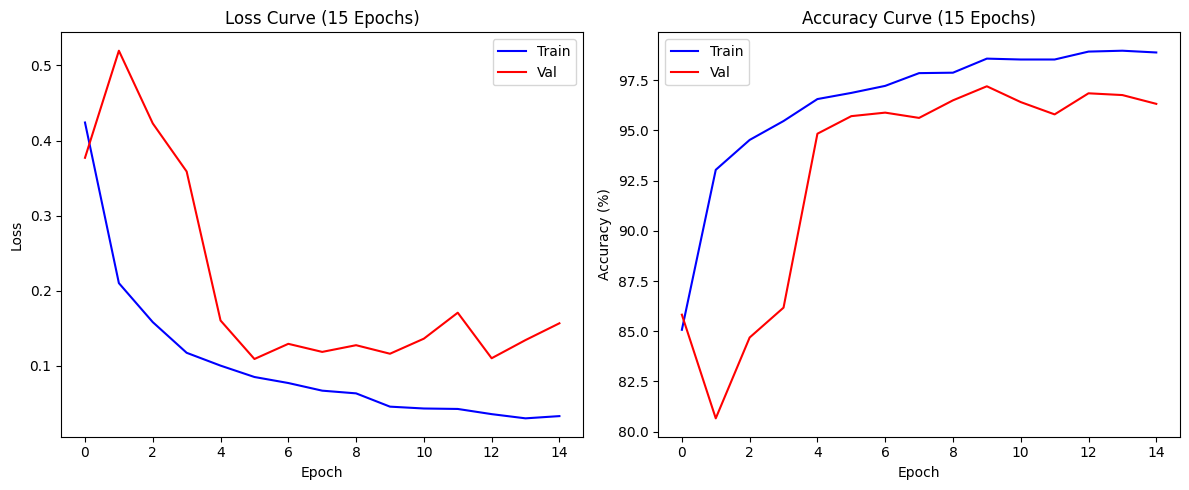

In [11]:
# 2. Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train')
plt.plot(val_losses, 'r-', label='Val')
plt.title('Loss Curve (15 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='Train')
plt.plot(val_accs, 'r-', label='Val')
plt.title('Accuracy Curve (15 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()




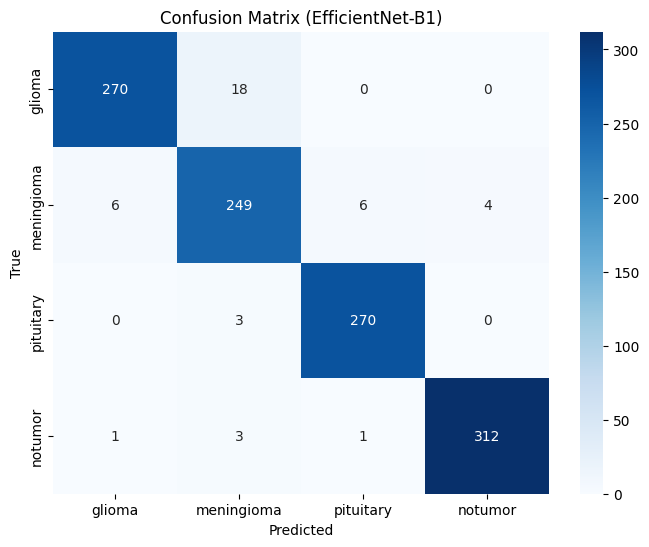

In [12]:
# 3. Confusion Matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (EfficientNet-B1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()